### Google drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### imports

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from matplotlib.patches import Rectangle
from google.colab.patches import cv2_imshow

In [5]:
box_df = pd.read_parquet('drive/MyDrive/object_detection/data/camera1_box.parquet').drop_duplicates()
img_df = pd.read_parquet('drive/MyDrive/object_detection/data/waymo_camera_image/camera1_data_part1.parquet').drop_duplicates()
box_cols = ['segment', 'frame_timestamp','camera_object_id',
            'box_center_x', 'box_center_y', 'box_size_x', 'box_size_y', 'type']
img_cols = ['image']
df = box_df[box_cols].join(img_df[img_cols])
df = df.loc[df.image.notna()].drop_duplicates()

# some Example ground Truths

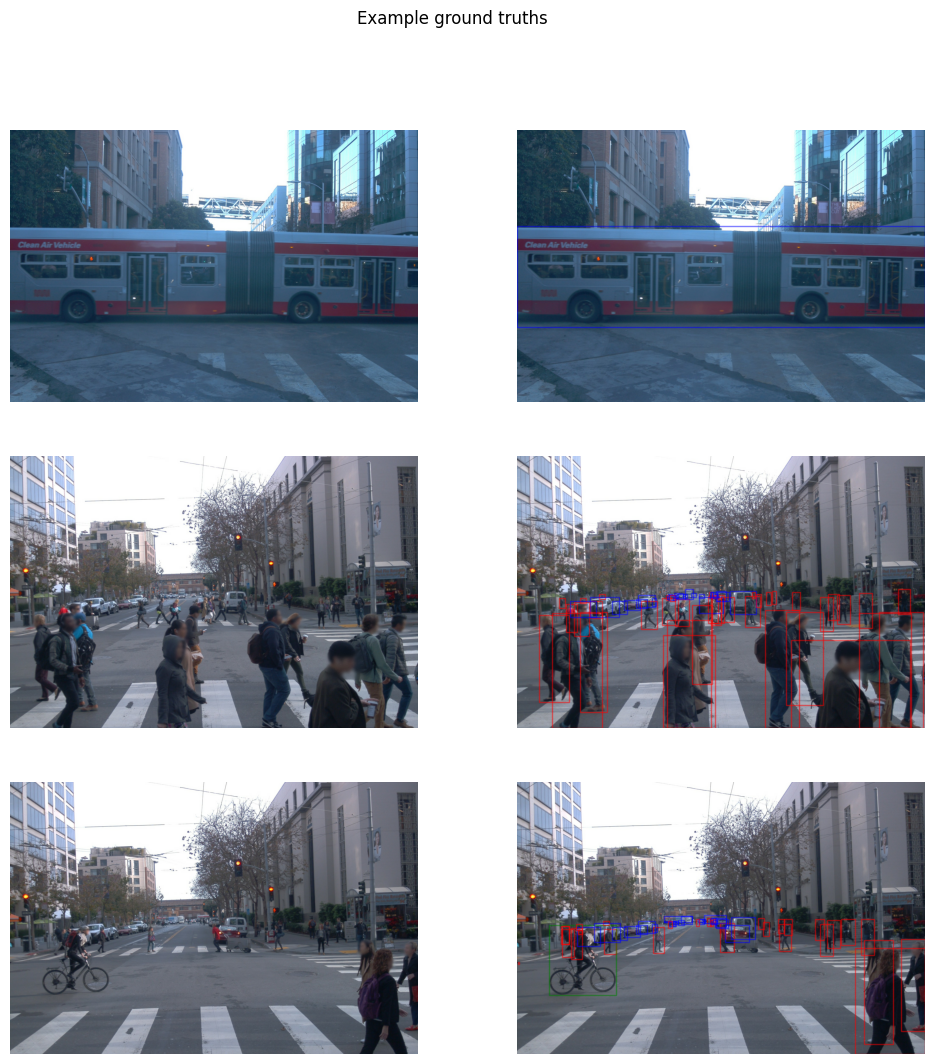

In [ ]:
c_map = {1:'b',2:'r',4:'g'}
def show_camera_image(data, layout):
    """Display the given camera image."""
    ax = plt.subplot(*layout)
    plt.imshow(tf.image.decode_jpeg(data.image))
    r,c,i = layout
    plt.grid(False)
    plt.axis('off')

    """Display the given camera with box."""
    ax = plt.subplot(r,c,i+1)
    plt.imshow(tf.image.decode_jpeg(data.image))
    this_frame = df.loc[data.name]
    if type(this_frame) == pd.Series: 
        this_frame = pd.DataFrame(this_frame).transpose()
    for i in range(this_frame.shape[0]):
        this_data = this_frame.iloc[i]
        lower_left_x = this_data.box_center_x - (this_data.box_size_x // 2)
        lower_left_y = this_data.box_center_y - (this_data.box_size_y // 2)
        box = Rectangle((lower_left_x, lower_left_y), 
                                this_data.box_size_x, 
                                this_data.box_size_y)
        box.set(fill=False,edgecolor=c_map[this_data.type], alpha=0.5)
        ax.add_patch(box)
    plt.grid(False)
    plt.axis('off')
    return ax
plt.figure(figsize=(12,12))
plt.suptitle('Example Ground Truths')
gb = df.groupby('type').agg('max','min')
img1 = df.loc[(df.type == 1) & (df.box_size_x == gb.loc[1].box_size_x)].iloc[0]
img2 = df.loc[(df.type == 2) & (df.box_size_x == gb.loc[2].box_size_x)].iloc[0]
img3 = df.loc[(df.type == 4) & (df.box_size_x == gb.loc[4].box_size_x)].iloc[0]
show_camera_image(img1, [3,2,1])
show_camera_image(img2, [3,2,3])
show_camera_image(img3, [3,2,5])
plt.show()

# more Example ground truths

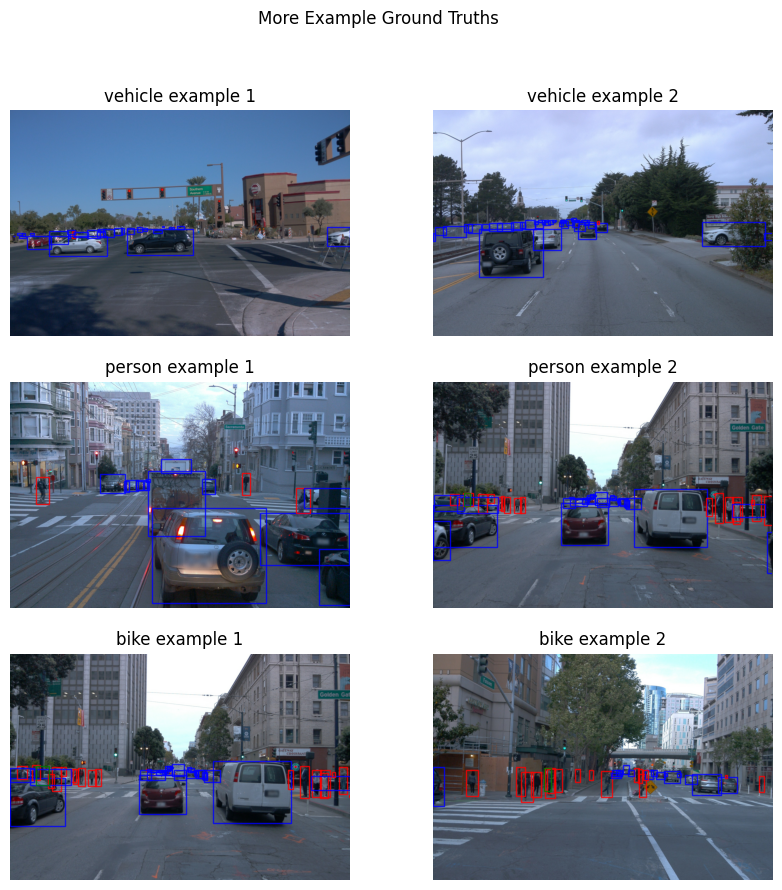

In [ ]:
c_map = {1:'b',2:'r',4:'g'}
type_map = {1:'vehicle', 2:'person', 4:'bike'}
def show_more_camera_image(data, layout):
    """Display the given camera with box."""
    r,c,plot_index = layout
    ax = plt.subplot(r,c,plot_index+1)
    plt.imshow(tf.image.decode_jpeg(data.image))
    this_frame = df.loc[data.name]
    if type(this_frame) == pd.Series: 
        this_frame = pd.DataFrame(this_frame).transpose()
    for i in range(this_frame.shape[0]):
        this_data = this_frame.iloc[i]
        lower_left_x = this_data.box_center_x - (this_data.box_size_x // 2)
        lower_left_y = this_data.box_center_y - (this_data.box_size_y // 2)
        box = Rectangle((lower_left_x, lower_left_y), 
                                this_data.box_size_x, 
                                this_data.box_size_y)
        box.set(fill=False,edgecolor=c_map[this_data.type], alpha=0.8)
        ax.add_patch(box)
    plt.grid(False)
    plt.axis('off')
    plt.title(f'{type_map[data.type]} example {plot_index%2+1}')
    return ax

plt.figure(figsize=(10,10))
plt.suptitle('More Example Ground Truths')

example_imgs = []
for i, t in enumerate(df.type.unique()):
    # get random image containing type t object
    example_imgs.append(
        df.loc[df.type == t]
        .sample(random_state=42).iloc[0]
    )
    # get random image containing type t object, from another segment
    example_imgs.append(
        df.loc[(df.type == t) & (df.segment != example_imgs[-1].segment)]
        .sample(random_state=42)
        .iloc[0]
    )

for i, img in enumerate(example_imgs):
    # get random image containing type t object
    show_more_camera_image(img, [3,2,i])

plt.show()

# more bike Example Ground Truths

In [ ]:
c_map = {1:'b',2:'r',4:'g'}
type_map = {1:'vehicle', 2:'person', 4:'bike'}
def show_bike_image(data, layout):
    """Display the given camera with box."""
    r,c,plot_index = layout
    ax = plt.subplot(r,c,plot_index+1)
    plt.imshow(tf.image.decode_jpeg(data.image))
    this_frame = df.loc[data.name]
    if type(this_frame) == pd.Series: 
        this_frame = pd.DataFrame(this_frame).transpose()
    for i in range(this_frame.shape[0]):
        this_data = this_frame.iloc[i]
        lower_left_x = this_data.box_center_x - (this_data.box_size_x // 2)
        lower_left_y = this_data.box_center_y - (this_data.box_size_y // 2)
        box = Rectangle((lower_left_x, lower_left_y), 
                                this_data.box_size_x, 
                                this_data.box_size_y)
        box.set(fill=False,edgecolor=c_map[this_data.type], alpha=0.8)
        ax.add_patch(box)
    plt.grid(False)
    plt.axis('off')
    plt.title(f'{type_map[data.type]} example {plot_index+1}')
    return ax

plt.figure(figsize=(10,40))
plt.suptitle('More Bike Ground Truths')

bike_imgs = []
t = 4 # bike type code
bike_df = df.loc[df.type == t]
for seg in bike_df.segment.unique():
    # get random image containing type t object
    bike_imgs.append(
        df.loc[((df.type == t) &
                (df.segment == seg)
        )]
        .sample(random_state=42)
        .iloc[0]
    )
    # get random image containing type t object, from same segment but another frame
    bike_imgs.append(
        df.loc[(
            (df.type == t) & 
            (df.segment == seg) &
            (df.frame_timestamp != bike_imgs[-1].frame_timestamp)
        )]
        .sample(random_state=42)
        .iloc[0]
    )

num_segments = len(bike_df.segment.unique())
for i, img in enumerate(bike_imgs):
    # get random image containing type t object
    show_more_camera_image(img, [num_segments,2,i])

print('num_segments:',num_segments)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Average label distribution

count    9704.000000
mean       18.980833
std        12.327843
min         1.000000
25%        10.000000
50%        17.000000
75%        27.000000
max        67.000000
Name: segment, dtype: float64

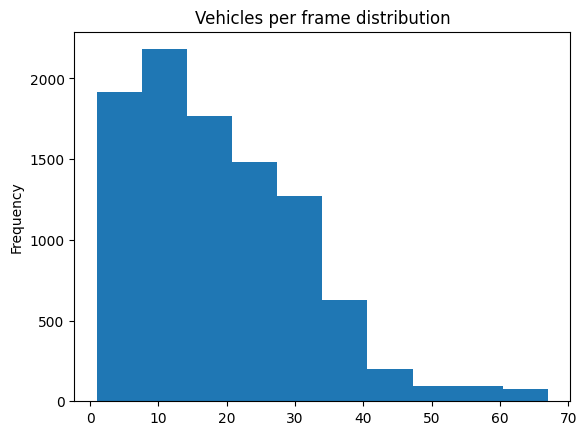

In [15]:
# Vehicles
vehicles_counts = df.loc[df.type==1].groupby('frame_timestamp').count()['segment']
display(vehicles_counts.describe())
vehicles_counts.plot(kind='hist')
plt.title('Vehicles per frame distribution')
plt.show()

count    5173.000000
mean        7.535279
std         8.123977
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max        40.000000
Name: segment, dtype: float64

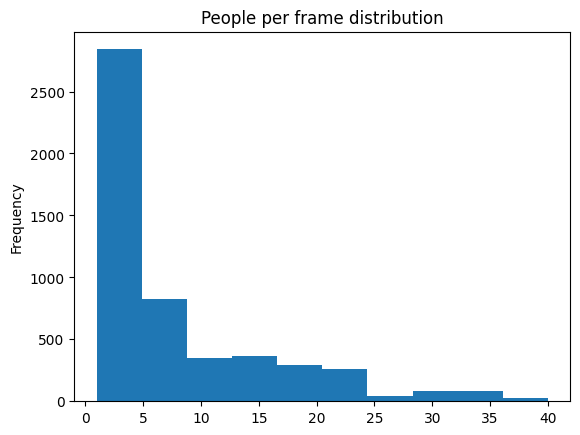

In [17]:
# People
people_counts = df.loc[df.type==2].groupby('frame_timestamp').count()['segment']
display(people_counts.describe())
people_counts.plot(kind='hist')
plt.title('People per frame distribution')
plt.show()